In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
)

In [3]:
# with open("maxent_llm_cache_large.pkl", "wb") as f:
#     import pickle
#     pickle.dump((variables, estimates), f)
with open("maxent_llm_cache_large.pkl", "rb") as f:
    import pickle
    variables, estimates = pickle.load(f)

In [4]:
import jax
import jax.numpy as jnp

from calibrated_response.energy_models.markov_random import MarkovRandomField
from calibrated_response.energy_models.neural import NeuralEnergyModel
from calibrated_response.energy_models.feature_weight import FeatureWeightModel


# nn_model = NeuralEnergyModel(len(variables), hidden_sizes=[128, 128, 128], n_freqs=4)
# params_pytree = nn_model.init_params(jax.random.PRNGKey(0))
# params = nn_model.pack_params(params_pytree)
# energy_fn = nn_model.energy_fn_flat
# init_x = jnp.zeros(len(variables))  
# energy_value = energy_fn(params, init_x)
# print("Initial energy value:", energy_value)

# mrf = MarkovRandomField.from_estimates(variables, estimates, clique_type='rbf')
# # params_pytree = mrf.zero_params()
# params_pytree = mrf.init_params(jax.random.PRNGKey(10))
# params = mrf.pack_params(params_pytree)
# energy_fn = mrf.energy_fn_flat
# # init_x = jnp.array([2.0, 1.0])  # Initial guess for (gdp_growth, inflation_rate)
# init_x = jnp.zeros(len(variables))  # Initial guess at the mean of the distribution
# energy_value = energy_fn(params, init_x)
# print(f"Energy at initial guess: {energy_value}")

In [10]:
from calibrated_response.maxent_smm.distribution_builder import DistributionBuilder
from calibrated_response.maxent_smm.maxent_solver import JAXSolverConfig

config = JAXSolverConfig(
    num_chains=1024,
    num_iterations=400,
    mcmc_steps_per_iteration=8,
    learning_rate=7e-3,

    l2_regularization=1e-3,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    continuous_prior="gaussian",
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config)

In [11]:

feature_model = FeatureWeightModel(feature_specs=builder.feature_specs)
params_pytree = feature_model.init_params(jax.random.PRNGKey(0))
params = feature_model.pack_params(params_pytree)
energy_fn = feature_model.energy_fn_flat
init_x = jnp.zeros(len(variables))  
energy_value = energy_fn(params, init_x)
print("Initial energy value:", energy_value)

solver, info = builder.run_solver(energy_fn=energy_fn, init_theta=params)

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

Initial energy value: 0.016062459
Compiled maxent solver
[MaxEntSolver] iter   50  max_err=0.626682  mean_err=0.080572  mean_squared_err=0.011660  accept=0.635  step_size=0.12740
[MaxEntSolver] iter  100  max_err=0.677801  mean_err=0.071229  mean_squared_err=0.009512  accept=0.617  step_size=0.13227
[MaxEntSolver] iter  150  max_err=0.716913  mean_err=0.066344  mean_squared_err=0.008717  accept=0.668  step_size=0.13732
[MaxEntSolver] iter  200  max_err=0.738807  mean_err=0.063367  mean_squared_err=0.008371  accept=0.666  step_size=0.14257
[MaxEntSolver] iter  250  max_err=0.740934  mean_err=0.061754  mean_squared_err=0.008155  accept=0.646  step_size=0.13392
[MaxEntSolver] iter  300  max_err=0.760581  mean_err=0.060122  mean_squared_err=0.007890  accept=0.619  step_size=0.13904
[MaxEntSolver] iter  350  max_err=0.760421  mean_err=0.058902  mean_squared_err=0.007723  accept=0.673  step_size=0.14435
[MaxEntSolver] iter  400  max_err=0.768857  mean_err=0.057647  mean_squared_err=0.007593 

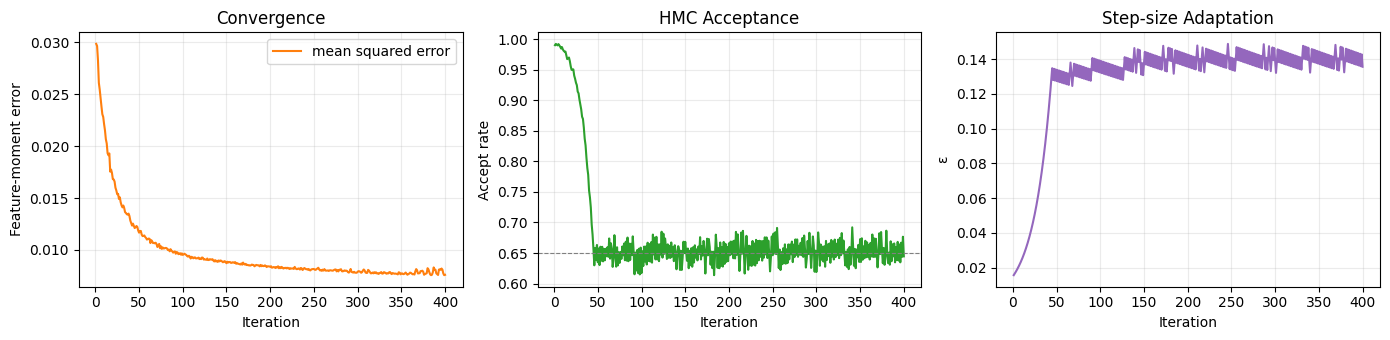

Final max error:  0.76886
Final mean error: 0.05765
Final accept rate: 0.645


In [12]:
history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

# axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
# axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].plot(history["iteration"], history["mean_squared_error"], label="mean squared error", color="C1")

axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [13]:
feature_means = builder.solver._batch_feature_fn(info['chain_states']).mean(axis=0)
feature_targets = builder.feature_targets
error = feature_means - jnp.array(feature_targets)
el = list(zip(error, estimates))
el.sort(key=lambda x: abs(x[0]), reverse=True)
for i, (err, est) in enumerate(el):
    print(f"{i+1}. {est.to_query_estimate()}: error = {err:.4f}")

# print("\nFeature means under the distribution:")
# for i, feature in enumerate(estimates):
#     feature_name = feature.to_query_estimate()
#     print(f"  {feature_name}: {feature_means[i]:.4f}")
#     print(f"    target: {feature_targets[i]:.4f}, error: {error[i]:.4f}")


1. P(ai_bubble_bursts_by_2030 = True | annual_ai_software_revenue < 300000000000.0) = 0.85: error = -0.7689
2. E[training_cost_sota_model | llm_performance_plateau = True] = 5000000000.0: error = -0.3648
3. E[fortune500_ai_adoption_rate | global_recession_occurs = True] = 65.0: error = -0.3355
4. P(ai_job_displacement_rate > 5.0 | fortune500_ai_adoption_rate > 75.0) = 0.75: error = -0.2235
5. E[training_cost_sota_model] = 1000000000.0: error = 0.2131
6. P(major_ai_company_failure = True) = 0.25: error = 0.1960
7. P(ai_bubble_bursts_by_2030 = True | llm_performance_plateau = True) = 0.7: error = 0.1730
8. E[ai_global_energy_share | training_cost_sota_model > 2000000000.0] = 7.0: error = -0.1699
9. E[fortune500_ai_adoption_rate] = 65.0: error = 0.1572
10. P(us_china_chip_conflict = True) = 0.55: error = 0.1530
11. P(strict_ai_regulation_passed = True | ai_job_displacement_rate > 10.0) = 0.85: error = -0.1479
12. P(fortune500_ai_adoption_rate > 90.0 | llm_performance_plateau = True) = 0.6

In [14]:
energy_model = info["energy_model"]
samples = energy_model.sample(n_samples=5000)

0: ai_bubble_bursts_by_2030: mean=0.535, std=0.328
1: annual_ai_software_revenue: mean=0.363, std=0.234
2: agi_breakthrough_achieved: mean=0.217, std=0.177
3: major_ai_safety_incident: mean=0.378, std=0.268
4: annual_vc_investment_ai: mean=0.233, std=0.174
5: llm_performance_plateau: mean=0.523, std=0.320
6: fortune500_ai_adoption_rate: mean=0.562, std=0.246
7: market_cap_top_ai_companies: mean=0.311, std=0.201
8: strict_ai_regulation_passed: mean=0.633, std=0.270
9: training_cost_sota_model: mean=0.236, std=0.172
10: ai_job_displacement_rate: mean=0.203, std=0.157
11: major_ai_company_failure: mean=0.360, std=0.267
12: global_recession_occurs: mean=0.589, std=0.297
13: us_china_chip_conflict: mean=0.458, std=0.290
14: ai_global_energy_share: mean=0.236, std=0.160


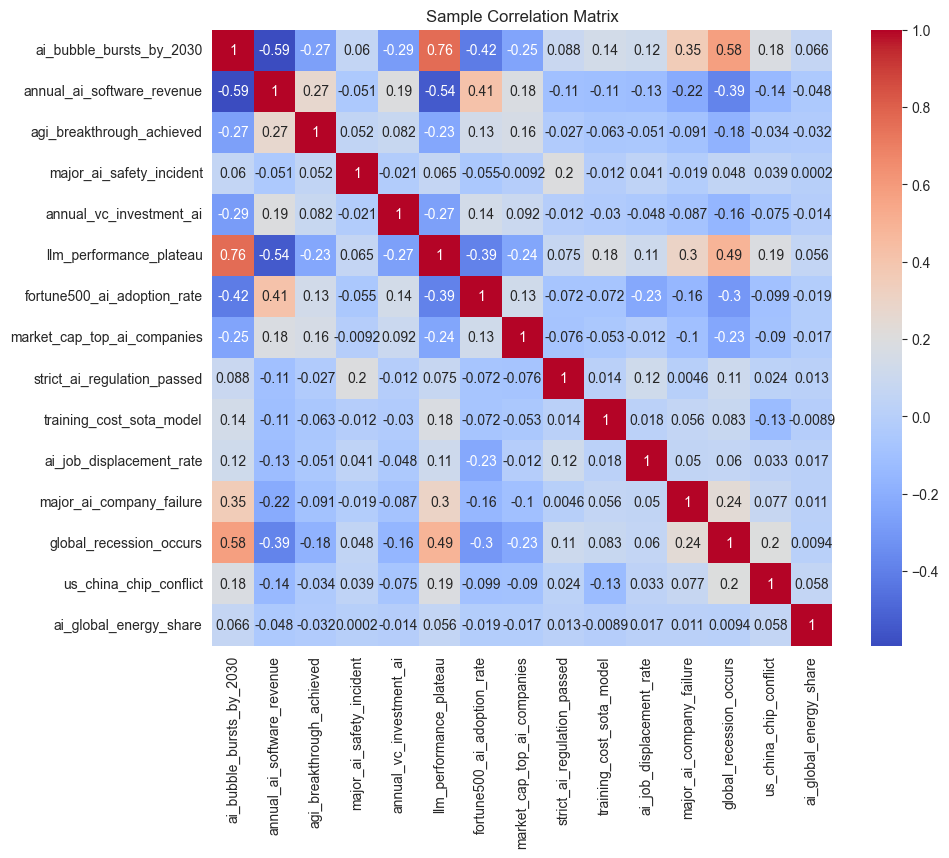

In [15]:
#calculate sample correlation matrix and plot as heatmap
import seaborn as sns
sns.set_style("whitegrid")
import jax.numpy as jnp
for i, var in enumerate(variables):
    print(f"{i}: {var.name}: mean={jnp.mean(samples[:, i]):.3f}, std={jnp.std(samples[:, i]):.3f}")

# Calculate sample correlation matrix
corr_matrix = jnp.corrcoef(samples, rowvar=False)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, xticklabels=[var.name for var in variables],
            yticklabels=[var.name for var in variables], cmap="coolwarm", annot=True)
plt.title("Sample Correlation Matrix")
plt.show()

In [17]:
corr_val = [(corr_matrix[i, j], variables[i].name, variables[j].name) for i in range(len(variables)) for j in range(i+1, len(variables))]
corr_val.sort(key=lambda x: abs(x[0]), reverse=True)
print("\nTop variable correlations:")
for corr, var1, var2 in corr_val[:10]:
    print(f"{var1} and {var2}: correlation = {corr:.3f}")


Top variable correlations:
ai_bubble_bursts_by_2030 and llm_performance_plateau: correlation = 0.758
ai_bubble_bursts_by_2030 and annual_ai_software_revenue: correlation = -0.592
ai_bubble_bursts_by_2030 and global_recession_occurs: correlation = 0.582
annual_ai_software_revenue and llm_performance_plateau: correlation = -0.538
llm_performance_plateau and global_recession_occurs: correlation = 0.486
ai_bubble_bursts_by_2030 and fortune500_ai_adoption_rate: correlation = -0.417
annual_ai_software_revenue and fortune500_ai_adoption_rate: correlation = 0.413
llm_performance_plateau and fortune500_ai_adoption_rate: correlation = -0.392
annual_ai_software_revenue and global_recession_occurs: correlation = -0.385
ai_bubble_bursts_by_2030 and major_ai_company_failure: correlation = 0.355



Top variable correlations:
ai_bubble_bursts_by_2030 and llm_performance_plateau: correlation = 0.439
ai_bubble_bursts_by_2030 and global_recession_occurs: correlation = 0.343
llm_performance_plateau and global_recession_occurs: correlation = 0.293
ai_bubble_bursts_by_2030 and annual_ai_software_revenue: correlation = -0.287
annual_ai_software_revenue and llm_performance_plateau: correlation = -0.268
ai_bubble_bursts_by_2030 and fortune500_ai_adoption_rate: correlation = -0.230
llm_performance_plateau and fortune500_ai_adoption_rate: correlation = -0.192
llm_performance_plateau and major_ai_company_failure: correlation = 0.178
fortune500_ai_adoption_rate and global_recession_occurs: correlation = -0.174
ai_bubble_bursts_by_2030 and major_ai_company_failure: correlation = 0.172


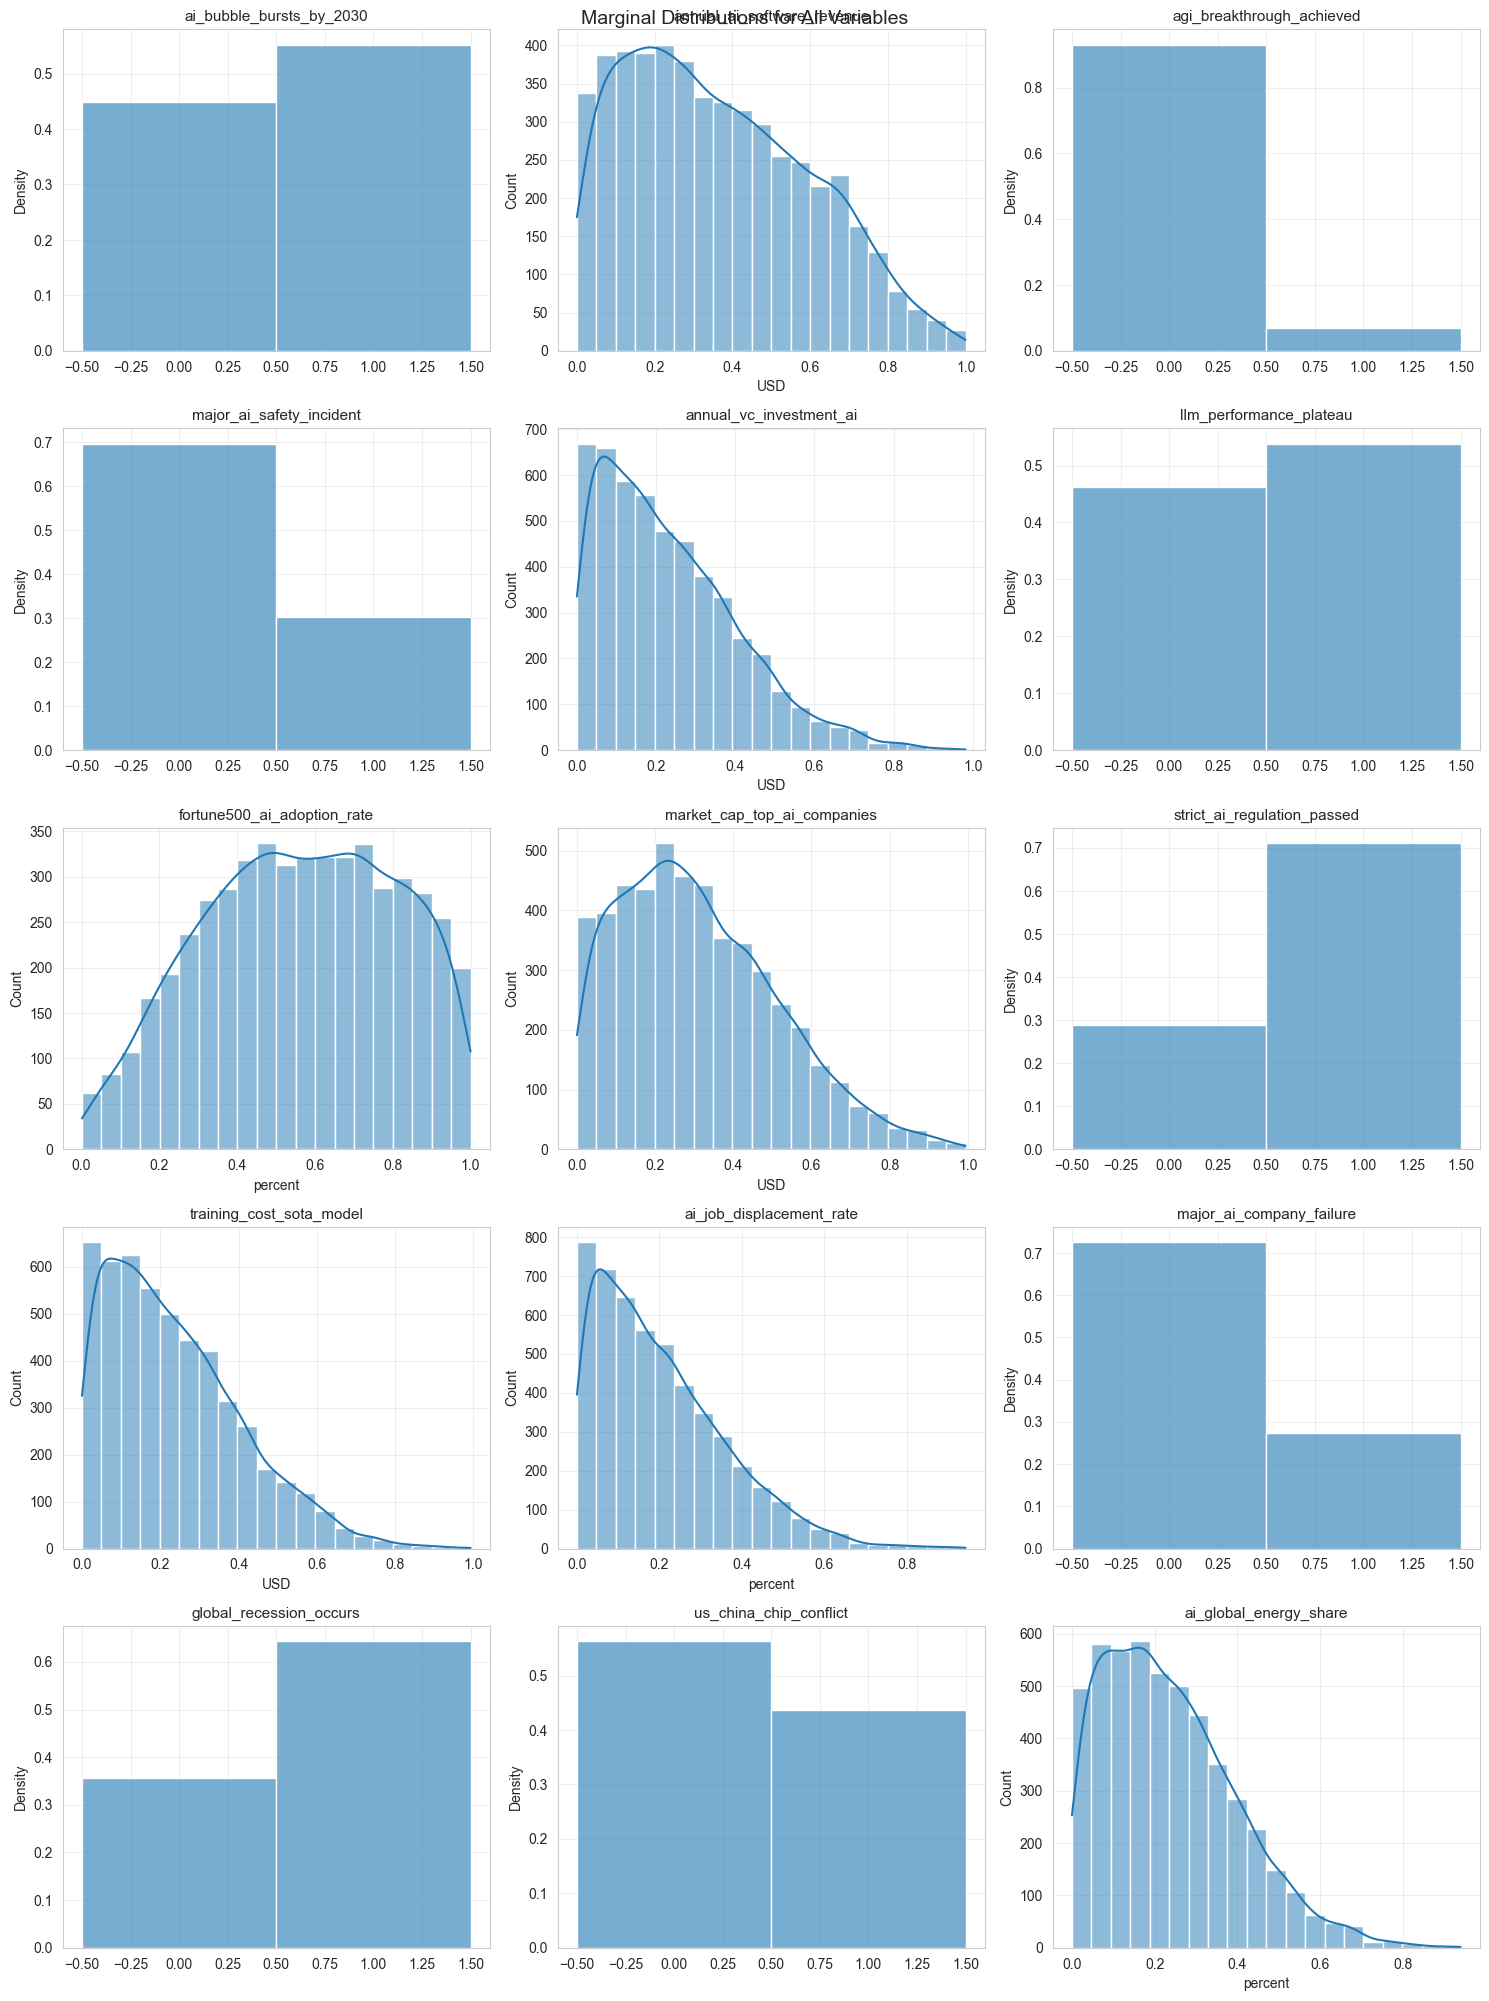

In [18]:
import seaborn as sns
from calibrated_response.models.variable import VariableType

# Plot all marginals in a grid
n_vars = len(variables)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()
    
for idx, var in enumerate(variables):
    if variables[idx].type == VariableType.BINARY:
        sns.histplot(samples[:, idx], bins=[-0.5, 0.5, 1.5], ax=axes[idx], color="C0", alpha=0.6, stat="density")
    else:
        sns.histplot(samples[:, idx], bins=20, kde=True, ax=axes[idx], color="C0")
        
    axes[idx].set_title(var.name, fontsize=11)
    axes[idx].set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All Variables', fontsize=14)
plt.tight_layout()
plt.show()

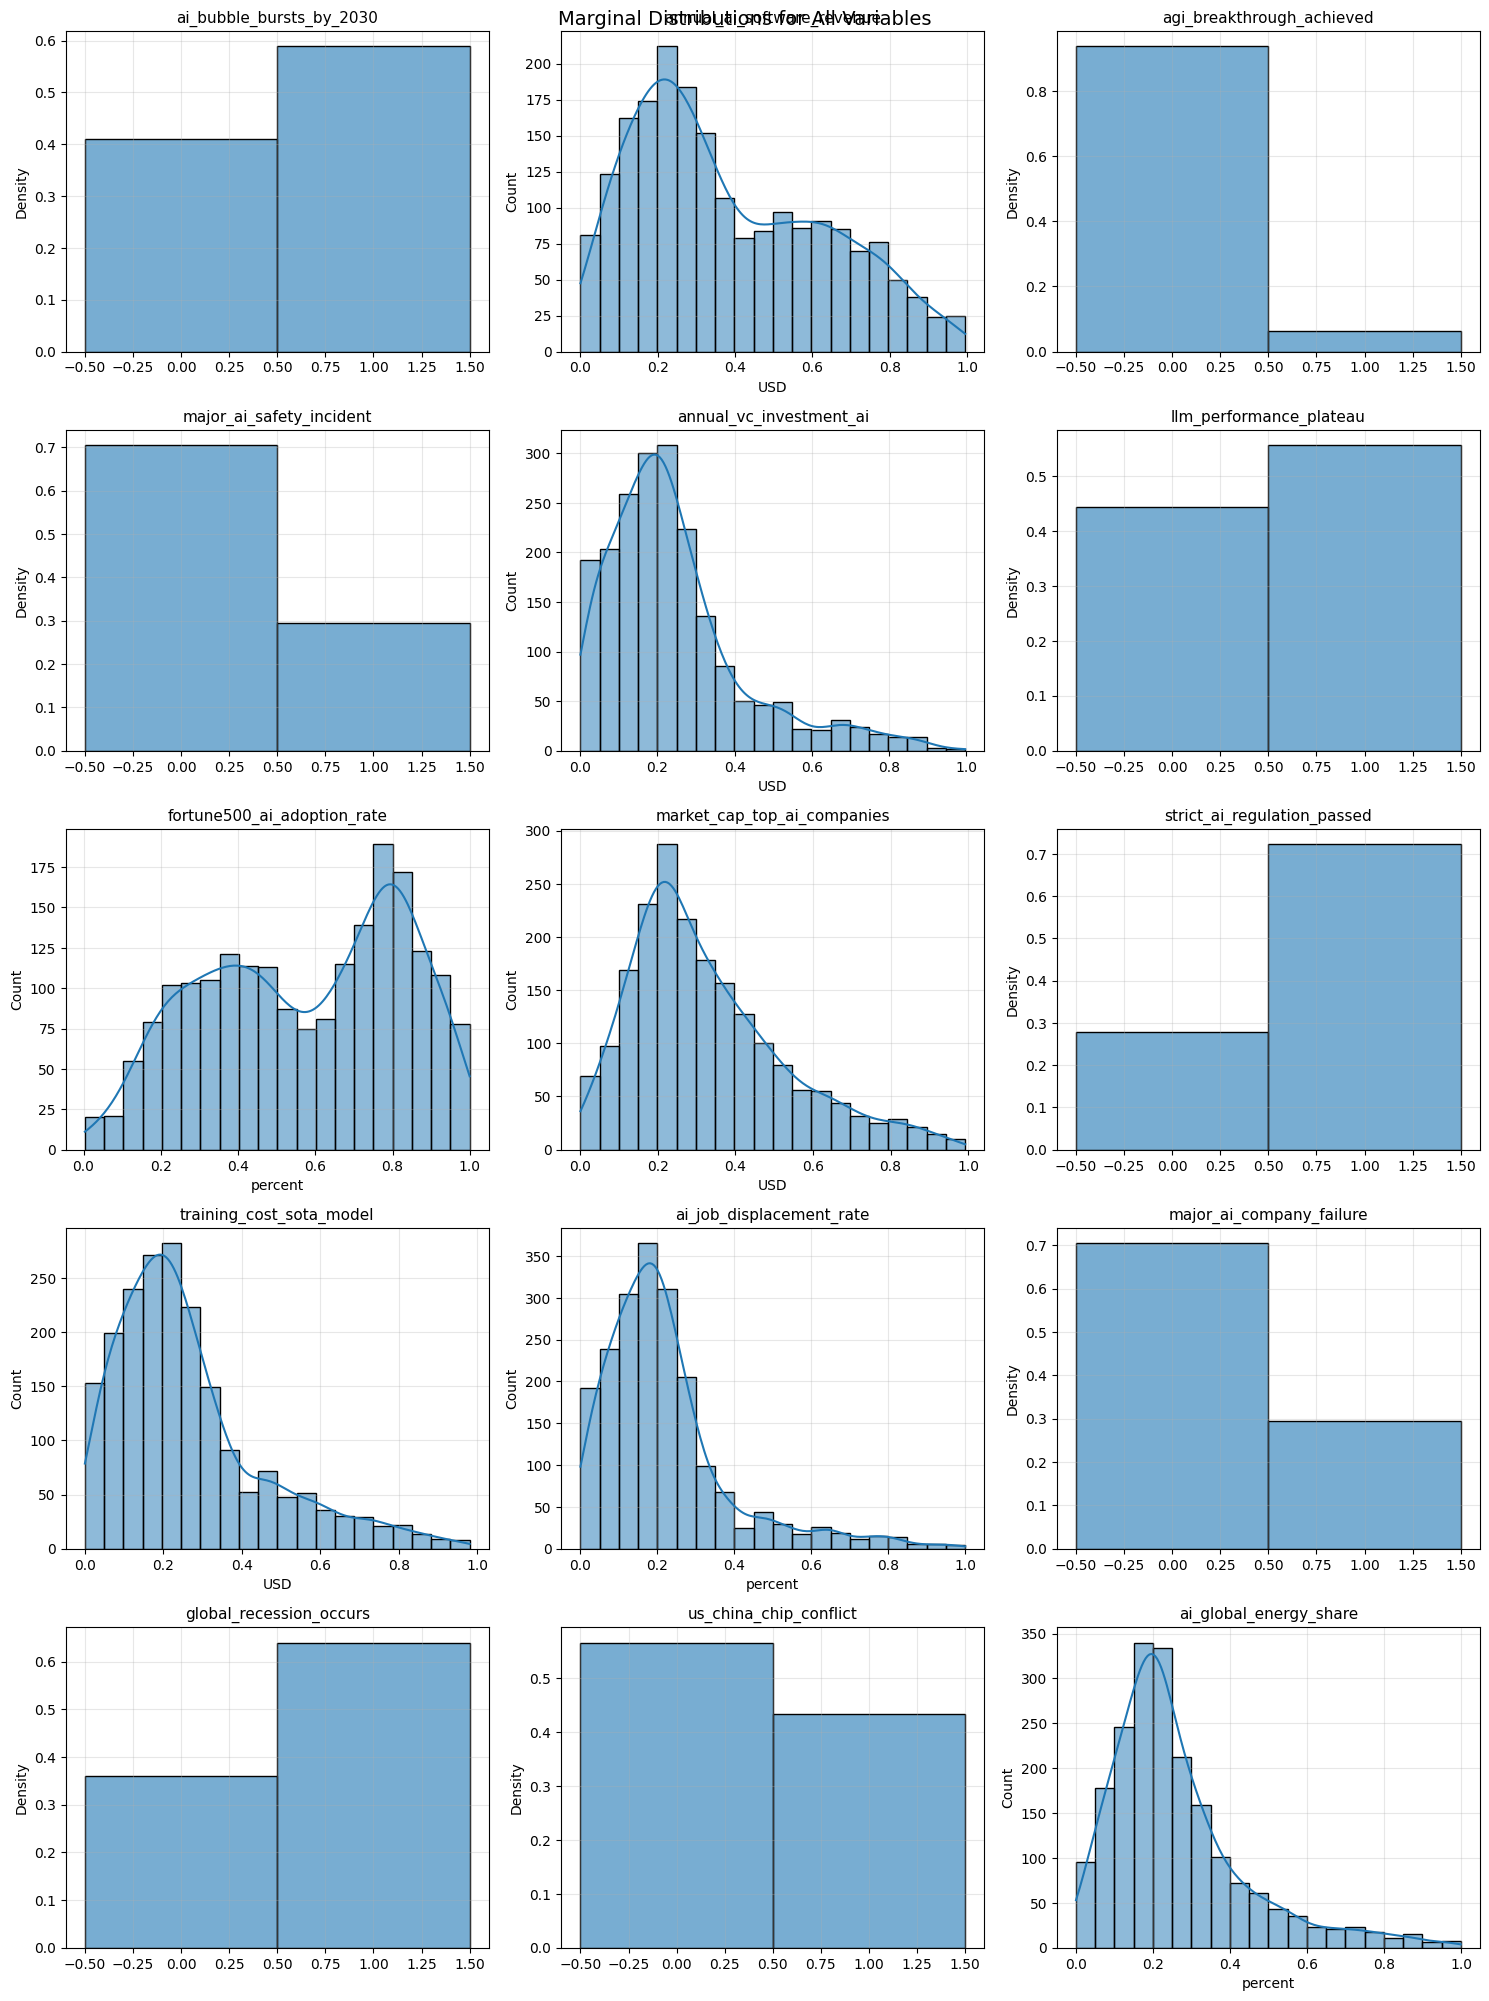

In [9]:
import jax.numpy as jnp
for i, var in enumerate(variables):
    print(f"{i}: {var.name}: mean={jnp.mean(samples[:, i]):.3f}, std={jnp.std(samples[:, i]):.3f}")

0: ai_bubble_bursts_by_2030: mean=0.572, std=0.336
1: annual_ai_software_revenue: mean=0.382, std=0.245
2: agi_breakthrough_achieved: mean=0.192, std=0.174
3: major_ai_safety_incident: mean=0.384, std=0.264
4: annual_vc_investment_ai: mean=0.242, std=0.180
5: llm_performance_plateau: mean=0.555, std=0.330
6: fortune500_ai_adoption_rate: mean=0.574, std=0.256
7: market_cap_top_ai_companies: mean=0.328, std=0.200
8: strict_ai_regulation_passed: mean=0.633, std=0.262
9: training_cost_sota_model: mean=0.265, std=0.194
10: ai_job_displacement_rate: mean=0.220, std=0.168
11: major_ai_company_failure: mean=0.378, std=0.268
12: global_recession_occurs: mean=0.606, std=0.299
13: us_china_chip_conflict: mean=0.468, std=0.281
14: ai_global_energy_share: mean=0.262, std=0.178


Text(0.5, 1.0, 'Joint Distribution of annual_ai_software_revenue and fortune500_ai_adoption_rate')

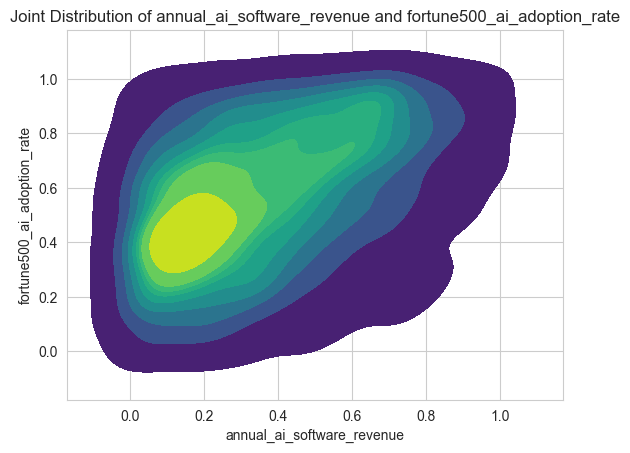

In [19]:
import seaborn as sns
sns.set_style("whitegrid")
# samples = samples[::5, :]
i1, i2 = 1, 6
sns.kdeplot(x=samples[:, i1], y=samples[:, i2], fill=True, 
            thresh=0.01, cmap="viridis")
plt.xlabel(variables[i1].name)
plt.ylabel(variables[i2].name)
plt.title(f"Joint Distribution of {variables[i1].name} and {variables[i2].name}")